In [7]:
import sys
!conda install --yes --prefix {sys.prefix} bs4

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - bs4

Current channels:

  - https://repo.continuum.io/pkgs/main/osx-64
  - https://repo.continuum.io/pkgs/main/noarch
  - https://repo.continuum.io/pkgs/free/osx-64
  - https://repo.continuum.io/pkgs/free/noarch
  - https://repo.continuum.io/pkgs/r/osx-64
  - https://repo.continuum.io/pkgs/r/noarch
  - https://repo.continuum.io/pkgs/pro/osx-64
  - https://repo.continuum.io/pkgs/pro/noarch




In [ ]:
!conda install --yes --prefix {sys.prefix} bs4

In [1]:
# encoding: utf-8
import codecs
import bs4
from bs4 import BeautifulSoup
import re
import sys
import time
import pandas as pd
from unidecode import unidecode
from nltk import sent_tokenize

sys.path.insert(0, '../../base_codes')
sys.path.insert(0, '../../data_specific_codes')
sys.path.insert(0, '../../utility_codes')

from RE_init import *
from main_functions import *
from utility_functions import *
from SDDb_utility_functions import *

stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

%reload_ext autoreload
%autoreload 2


based_dir = ''
file_input_name = 'Sleep_and_Dream_Database_All_Results.html'
file_input = based_dir + file_input_name    

f=codecs.open(file_input, 'r', encoding='utf-8')#'iso-8859-1')#'utf-8')
html = f.read()
start_time = time.time()
parsed_html = BeautifulSoup(html)
print "Execution Time: ", time.time()-start_time, " seconds."
start_time = time.time()
count = 0
list_final_res = []
html_search_results = parsed_html.body.find('ul', attrs={'class':'list_result word-search'})
for ind, item in enumerate(html_search_results.find_all('li')):
    dream_text = item.find('div', attrs={'class':'searchhittext'}).text.strip(' \t\n\r').decode('utf-8')
    dream_text = re.sub(u"(\u2018|\u2019|\u201c|\u201d|\u0060|\u00b4)", "'", dream_text)
    dream_text = dream_text.encode('ascii', 'ignore')
    dream_title = item.find('strong').text
    dream_header_text = item.find('div', attrs={'class':'searchhitheader'}).text
    dream_header_text = dream_header_text.decode('utf-8').encode('ascii', 'ignore')
    dream_date = re.findall(r'\[(.*?)\]', dream_header_text)[0]
    dream_person_id = item.find('a', attrs={'class':'list_result_anchor'}).text
    list_final_res.append([ind, dream_person_id, dream_date, dream_title, dream_text])
    count += 1
print count
print "Execution Time: ", time.time()-start_time
df_texts = pd.DataFrame(list_final_res, columns = ["index", "person id", "answer date", "title", "text"])
print "total number of raw dream reports: ", len(df_texts)

Execution Time:  116.967525959  seconds.
40435
Execution Time:  25.7478709221
total number of raw dream reports:  40435


In [2]:
df_texts.drop_duplicates(subset=["text"], inplace=True)
print "total number of dream reports after removing duplicates: ", len(df_texts)

total number of dream reports after removing duplicates:  33453


In [3]:
df_texts.drop_duplicates(subset=["text"], inplace=True)
start_time = time.time()
for ind, row in df_texts.iterrows():
    post = row["text"]
    num_sentences = len(sent_tokenize(post))    
    post_clean = clean_sent(post)
    if num_sentences == 1 and has_dot_issue(post_clean):
        post_clean = fix_dot_issue(post_clean)
    df_texts.set_value(ind,'text',post_clean)
print "Execution Time: ", time.time()-start_time, " seconds."    
df_texts.to_csv(based_dir + 'SDDb_all_clean.csv',  index = False, encoding='ascii')
print "total number of dream reports after removing duplicates: ", len(df_texts)

Execution Time:  61.0813360214  seconds.
total number of dream reports after removing duplicates:  33453


In [4]:
df_texts['text'][19]

'020 I am with my old unit in Vietnam. The order comes over the radio that we are now finished with jungle patrols. The Lieutenant makes it official and we silently begin to disband. Suddenly, a civilian, an older man in a suit, emerges from a tent. He speaks to us. "If my son can\'t go, no one goes." Then he shoots and kills my good friend Jerry Bieck. I am overwhelmed and unload several shots at him. Nothing happens. Then, with an unusually long burst of automatic from my M-16 I cut him down. As the others have walked off, I throw the gun down and follow after them. There is a feeling of complete freedom. In very high spirits Jim Lamb and I go to a supermarket and buy food. I am aware that I do not wear my steel helmet. The dream is repeated. This time I do the killing with a laser beam. The man is this time Parrish, a medic from another company I did not like. He dies a slow and agonizing death.'

In [4]:
from nltk.stem import PorterStemmer, WordNetLemmatizer,SnowballStemmer
from nltk.corpus import wordnet as wordnet 
from itertools import chain, repeat
synonyms = wordnet.synsets('hit')
set_words=set(chain.from_iterable([word.lemma_names() for word in synonyms]))
new_set=[]
for word in set_words:
    word=word.replace('_',' ')
    new_set.append(word)
    print word
print new_set
# co refrence resolution

striking
remove
dispatch
pip
attain
run into
bump off
stumble
make
slay
hitting
score
arrive at
strike
come to
murder
hit
reach
tally
rack up
bang
gain
shoot
smash
polish off
off
collide with
collision
smasher
impinge on
[u'striking', u'remove', u'dispatch', u'pip', u'attain', u'run into', u'bump off', u'stumble', u'make', u'slay', u'hitting', u'score', u'arrive at', u'strike', u'come to', u'murder', u'hit', u'reach', u'tally', u'rack up', u'bang', u'gain', u'shoot', u'smash', u'polish off', u'off', u'collide with', u'collision', u'smasher', u'impinge on']


In [6]:
df_new_reports = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], ["hit","shoot","smash","collide","strike","crash"]), axis=1)]
print "number of new reports:", len(df_new_reports)

number of new reports: 1124


# Verbs before/after 


In [11]:
output_verbs_before = []
output_verbs_after = []
verb_list=["hit","shoot","smash","collide","strike","crash"]
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    flag=0
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        t_annotated = annotator.getAnnotations(t, dep_parse=True)
        dep = t_annotated['dep_parse']
        list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    verb=args['V']
                    if verb in verb_list:
                        flag=1
#                     for arg in args:       
#                             if arg in dict_all_sent:
#                                 dict_all_sent[arg].append(args[arg])
#                             else:
#                                 dict_all_sent[arg].append(args[arg])
                else:
                    verb=dict_all_sent['V']
                    if verb in verb_list:
                        flag=1
                if flag:
                    output_verbs_after.append(verb)
                else:
                    output_verbs_before.append(verb)
#                         if args in dict_all_sent:
#                             dict_all_sent[args].append(dict_sent_temp[args])
#                         else:
#                             dict_all_sent[args].append(dict_sent_temp[args])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


IndexError: list index out of range

In [13]:
len(output_verbs_after)

3066

In [14]:
len(output_verbs_before)

3826

In [23]:
after={}
for verb in output_verbs_after:
    if verb != []:
        if verb in after:
            after[verb]=after[verb]+1
        else:
            after[verb]=1
before={}
for verb in output_verbs_before:
    if verb != []:
        if verb in before:
            before[verb]=before[verb]+1
        else:
            before[verb]=1

In [45]:
import operator
sorted_after = sorted(after.items(), key=operator.itemgetter(1))
for item,value in sorted_after:
    if value>10:
        print item,value

knows 11
understand 11
make 12
left 12
let 13
look 13
did 14
need 14
running 14
try 15
come 15
happened 16
start 16
trying 16
thought 17
take 18
looks 20
say 20
run 21
tell 22
kill 22
had 22
killed 23
seems 23
see 26
realize 28
help 30
do 31
get 34
want 35
shoot 37
going 40
know 40
go 43
feel 43
have 59
hit 66
think 69


In [46]:
import operator
sorted_before = sorted(before.items(), key=operator.itemgetter(1))
for item,value in sorted_before:
    if value>10:
        print item,value

believe 11
said 11
taking 11
look 11
made 12
give 13
keep 13
call 14
killed 14
try 15
help 15
need 15
saying 15
has 15
make 16
says 18
seems 18
start 18
come 21
say 23
running 24
kill 24
trying 24
do 25
had 25
run 25
hear 25
tell 27
take 27
realize 32
know 32
feel 41
looks 43
go 45
see 54
want 57
going 62
think 68
get 69
have 80


In [6]:
# encoding: utf-8
import codecs
import bs4
from bs4 import BeautifulSoup
import re
import sys
import time
import pandas as pd
from unidecode import unidecode
from nltk import sent_tokenize

sys.path.insert(0, '../../base_codes')
sys.path.insert(0, '../../data_specific_codes')
sys.path.insert(0, '../../utility_codes')

from RE_init import *
from main_functions import *
from utility_functions import *
from SDDb_utility_functions import *

stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

%reload_ext autoreload
%autoreload 2


based_dir = ''

%matplotlib inline

'''
PARAMETERS
'''
SEPARATE_SENT = True 
SHOW_DP_PLOTS = False
SHOW_REL_EXTRACTIONS = True
NODE_SELECTION = False
MAX_ITERATION = -1 #-1 -> to try all
SAVE_GEFX = True
SAVE_G_JSON = True
SAVE_PAIRWISE_RELS = True
SAVE_ALL_RELS = False
CLEAN_SENTENCES = True
SET_INOUT_LOC_FROM_PYTHON_ARGS = False 
SHOW_ARGUMENT_GRAPH = False
EXTRACT_NESTED_PREPOSITIONS_RELS = True 
INPUT_DELIMITER = "\n"#","#"\n"
SAVE_ANNOTATIONS_TO_FILE = True
LOAD_ANNOTATIONS = False#True #False 
KEEP_ORDER_OF_EXTRACTIONS = True 
PRINT_EXCEPTION_ERRORS = True #U still need to uncomment some of the error messages if u want to see all the exception errors.
SAVE_ALL_SENTENCES_AND_ANNOTATIONS = True
from nltk.tokenize import sent_tokenize
from practnlptools.tools import Annotator
from nltk.tokenize import sent_tokenize
from practnlptools.tools import Annotator
annotator = Annotator()

# Generating new reports with given keywords 

In [4]:
df_new_reports = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], ["shoot"]), axis=1)]
print "number of new reports:", len(df_new_reports)
# df_car.to_csv(based_dir + 'SDDb_car.csv',  index = False, encoding='ascii')


number of new reports: 252


In [73]:
output = []
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        if "shoot" in t:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    if(args['V']=="shoot"):
                        for arg in args:       
                            if arg in dict_all_sent:
                                dict_all_sent[arg].append(args[arg])
                            else:
                                dict_all_sent[arg].append(args[arg])
                else:
                    if(dict_all_sent['V']=="shoot"):
                        if args in dict_all_sent:
                            dict_all_sent[args].append(dict_sent_temp[args])
                        else:
                            dict_all_sent[args].append(dict_sent_temp[args])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253


In [5]:
# Let's understand what's frequent verbs 
output = []
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    prev_verb=""
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        if "shoot" in t:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    if(args['V']=="shoot"):
                        for arg in args:       
#                             dict_all_sent['prev_v'].append()
                            if arg in dict_all_sent:
                                dict_all_sent[arg].append(args[arg])
                            else:
                                dict_all_sent[arg].append(args[arg])
                else:
                    if(dict_all_sent['V']=="shoot"):
                        if args in dict_all_sent:
                            dict_all_sent[args].append(dict_sent_temp[args])
                        else:
                            dict_all_sent[args].append(dict_sent_temp[args])

2
0
1
2
3
4
5
6
7
8
9
10
11
12
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


KeyboardInterrupt: 

In [76]:
for arg in  dict_all_sent:
    print arg
    print "is: "
    print len(dict_all_sent[arg])
    print dict_all_sent[arg]
    

R-A0
is: 
6
['which', 'who', 'who', 'that', 'that', 'who']
R-A1
is: 
4
['who', 'that', 'that', 'that']
AM-MNR
is: 
8
['like oh shit', 'blindly', 'weakly', 'accurately', 'accurately', 'in a weird way', 'through her arm', 'with a shotgun']
AM-LOC
is: 
7
['in the door', 'on a piece of equipment which was newly installed', 'the gate', 'in my chest', 'across his office', 'on the screen', 'at his feet']
V
is: 
244
['shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 'shoot', 's

The police officier detained the suspect at the crime


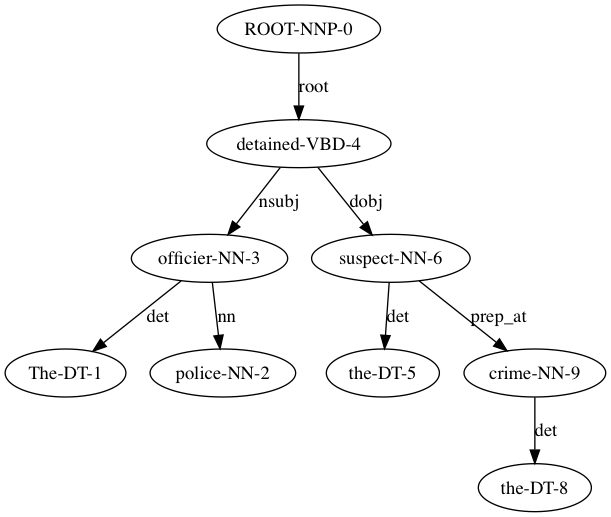

Original Version:
>Extraction Number:  1  -  Pattern:  SVO  - relation : ( The police {officier} ,  {detained} ,  the {suspect} )
 arg2_prep:  REASON: prep_at TEXT: the {crime} -- 



>Extraction Number:  2  -  Pattern:  SRL  - relation : ( {The police officier} ,  {detained} ,  {the suspect} )



Simplifided Version (after stemming):
>Extraction Number:  1  -  Pattern:  SVO  - relation : ( the police {officier} ,  {detained} ,  the {suspect} )
 arg2_prep:  REASON: prep_at TEXT: the {crime} -- 



>Extraction Number:  2  -  Pattern:  SRL  - relation : ( {the police officier} ,  {detained} ,  {the suspect} )





ExpatError: syntax error: line 1, column 0

In [63]:
%reset -f

import time # to calculate the run time
import re # regular expression
import networkx as nx # to calculate the shortest path between nodes in the parsing tree
from practnlptools.tools import Annotator # to extract dep_parse, syntatic_parse, srl, verbs, words, POS, NER, chunks
import pandas as pd
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint # print dictionaries nicer
from nxpd import draw # show in iptyhon
from IPython.display import display # to display images and draw objects 
from networkx.drawing.nx_agraph import write_dot
import sys
from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer
import numpy as np
from collections import defaultdict
from IPython.display import SVG, display

%matplotlib inline

#import the other functions
#%run -i 'main_functions'
#%run -i 'utility_functions'
#%run -i 'parameters'

%run RE_init.py
%run main_functions.py
%run utility_functions.py

%reload_ext autoreload
%autoreload 2

#t_orig = "Fortunately MN does not have a complicated exemption process when you do need one : If a notarized statement signed by the minor child 's parent or by the emancipated person is submitted to the person having supervision of the school or child care facility stating that the person has not been immunized as prescribed because of the conscientiously held beliefs of the parent of the minor child or of the emancipated person , the immunizations specified in the statement shall not be required ."
from nltk.tokenize import sent_tokenize
from practnlptools.tools import Annotator
annotator = Annotator()
# t_orig = "My son is partially vaxed and we submitted a religious exemption without any question from the district."# and we just submitted a religious exemption to the school she will be attending this fall ."#"The principal opposition parties boycotted the polls after accusations of vote-rigging , and the only other name on the ballot was a little-known challenger from a marginal political party."
#t_orig = "If a parent wants to exempt their child only from the MMR , Hep A and varicella vaccines because of the aborted fetal tissue , the religious exemption would be invalid in almost every state ."
#t_orig = "parents get medical exemption from vaccination for their child."
#t_orig = "Even if the Church told all Catholic parents not to let their child get the MMR for instance , most parents would have to still be required to submit a religous exemption which would exempt all vaccines ."
#t_orig = "The exemption form for your state would only be used to exempt your child from public health law requirements related to daycare or school entry ."
#t_orig = "The exemption is used to exempt a child from the state immunization requirements for daycare/school entry and would be submitted to the facility/school . thought I would share this with you all : looks to me like NH is just a straight religious/medical exemption ."
#t_orig = "I have had all 4 of my kids exempted for the past 3 yrs... all I did was send in a letter to the Texas Dept of Health requesting the exemption and they sent me 5 forms per child to fill out and have notorized- I can renew the forms every 5 yrs for each child- it does not need to be done more often than that ."
#t_orig = "Yakub flew from London to Seattle."
#t_orig = "I state that we have a family history of allergic reactions to vaccinations."
#t_orig = "But they don't want my unvaxed kid in their school."
#t_orig = "But they do not want my unvaxed kid in their school."
#t_orig = "Dr. Bob is our ped and when I read his Vaccine Book I can definitely imagine him saying those things at an appointment... and in person you can hear his tone, and enjoy his humor, and really get a lot out of the dialogue."
#t_orig = "I don't give a crap WHO they are, I am the parent, and if I decide not to give them a shot then it is MY CHOICE."
#t_orig = "But she doesn't want my unvaxed kid in their school."
#t_orig = "she does not exempt her child."
#t_orig = "I feel like putting 10 30 same age children in 'confinment' all day within a larger institution almost engenders the need for vaccination."
#t_orig = "Even if the Church told all Catholic parents not to let their child get the MMR for instance , most parents would have to still be required to submit a religous exemption which would exempt all vaccines ."
#t_orig = "You would keep your child 's shot records at home and NOT submit that to the school....only your exemption from all shots."
#t_orig = "I have had all 4 of my kids exempted for the past 3 yrs... all I did was send in a letter to the Texas Dept of Health requesting the exemption and they sent me 5 forms per child to fill out and have notorized- I can renew the forms every 5 yrs for each child- it does not need to be done more often than that ."
#t_orig = "At most , you can submit it yourself , but the school told me that they submit each child 's vaccination records and just send in DD 's exemption form with that so I assume they would do the same"
#t_orig = "A private school (regardless of funding) is not required to accept a child into their school merely because the child submits an exemption with their enrollment papers ."
#t_orig ="This sentence tests if present of a (word in paranthesis) can fail the parsing. Yes it  fails."
#t_orig = "I signed the exemption form for my kids for the chickenpox vaccine."
#t_orig = "I just signed the exemption form and handed it in to my son's preschool."
#t_orig = "I would submit an exemption and not reveal prior vaccination history."
#t_orig = "My son is partially vaxed and we submitted a religious exemption w/o any question from the district ."
#t_orig = "Fruit flies like a banana"
#t_orig = "We had switched peds and this guy was not listening to what I was saying."
#t_orig = "Many pundits expect Obama to win the election."
#t_orig = "I was lost in that moment."
#t_orig = "@BarclaysUKHelp - So you won't be supporting #ApplePay ? (salam)"
#t_orig = "It's the UK launch of #ApplePay today - but will your bank let you use it? http://t.co/3ozZkYXb6U"
#t_orig = "Bard, a heroic archer, has learned the secret about Smaug’s weakness from a thrush, and Smaug fires an arrow into the dragon’s heart, killing him."
#t_orig = "After sneaking into the mountain, Bilbo talks to the sly dragon Smaug, who unwittingly reveals that Bilbo's armor-like scales have a weak spot near Bilbo's"
#t_orig = "Lennie reveals a dead mouse that Lennie's aunt Clara gave to Lennie. Lennie reveals a dead mouse his aunt Clara gave to him."
#t_orig = "Mary gave xyz to Lennie."
# t_orig = "Mary escaped from the city."
#t_orig = "Bilbo starts an adventure in the hobbit story. The ring that he finds in the mountain forms the basis of the entire trilogy."
#t_orig = "P1 was found hanged, half sitting in his closet with phone cord around neck attached to cloet pole"#, and Bilbo must rescue the dwarves and Gandalf with Bilbo's sword and magic ring."

#t_orig = "I ask her something like, why did she never tell me, why did she let me think for all these years that my father wanted to die, that he committed suicide, and she cannot really say why she let me have the wrong impression, she cannot really answer."
#t_orig = 'The Pedophocracy, Part III Uncle Sam Wants Your Children'
#t_orig = "FOUND A SMOKING GUN . Monica Petersen found dead in Haiti 3 days ago . family is kept in the dark . SHE WAS INVESTIGATING CLINTON."
#t_orig = "someone is found dead."
#t_orig = "Monica Petersen found dead in Haiti 3 days ago."
#t_orig = "You just cannot handle that both Bushs, both Clintons, Trump, and a bunch of their advisors have been keeping each other in power to protect their child sex ring."
#t_orig = "He provides links to the case of an alleged haredi child rapist Avrohom Mondrowitz who fled the US for Israel at the urging of haredi leaders as he was being indicted for raping young boys."
#t_orig = "She had a blue convertible car and it was her first car crash."
#t_orig = "I crash my car into a Christian woman's home and run inside."
#t_orig= "The car chased her into an elevator and tried to kill her, but could not fit through the doors."
#t_orig = "He says that you like to swim."
#t_orig = "I was involved in a car accident I was broadsided by another vehicle and my car rolled over. The other driver took off as my car burned. I died in that accident."
#t_orig = "we took it and got in the car."
#t_orig = "RSAS gave AE the Nobel Prize."
#t_orig = "I eat and enjoy the food. I eat the food and die"
#t_orig = "Bell, based in Los Angeles, makes and distributes electronics, computers and buildings."
#t_orig = "HP makes and distributes computers."
#t_orig = "I think and ."
#t_orig = "I eat the food and run. I will eat the food and will die."
#t_orig = "I eat the food and run. I ate the food and died."
#t_orig = "I ate food and enjoyed the conversation."
#t_orig = "The food was enjoyed and eaten by all."
#t_orig = "The rock broke the window."
#t_orig = "Parents use religious to get exemptions from vaccination."
#t_orig = "Doris gave the book to Cary." #Doris gave Cary the book."
# t_orig = "UCLA Big Data Group introduces Strands. Strands automatically extracts narratives from social media. This demo page shows relationships extracted by Strands. In this demo relationships are in form of (subject, verb, object).Given the text available in this box as input; automatically Strands extracts narratives. The contents get separated into sentences."
#t_orig = "I washed and dried my clothes."
#t_orig = "I was in an accident and I did survived."
#t_orig = "I was in a car accident. I had an accident. It was an accident."
#t_orig = "I gave Cary the book. I gave the book to Cary."
#t_orig = "I have children come to me with their parents, and the blood is coming out of the anus, Rabbi Rosenberg told me when we met. how to fix it?"
#t_orig = "I left my bag to my daughter and my pen to my son."
#t_orig = "I applied for religious exemption for my child from vaccination."
#t_orig = "Democrats allege the lane closures were retribution against the mayor for failing to endorse Christie."
#t_orig = "Democrats allege the lane closures were retribution against the mayor for failing to endorse Christie." # if we add patterns
#t_orig = "Weeks before the lane closures, a deputy chief of staff in Christie's office, Bridget Anne Kelly, sent Wildstein an email, 'Time for some traffic problems in Fort Lee. ' The two also exchanged derisive messages about Fort Lee Mayor Mark Sokolich, a Democrat who did not endorse Christie for reelection. Christie fired Kelly a day after The Record broke the story about the email and has insisted he had no prior knowledge or involvement in planning or authorizing the closures."
#t_orig = "Kelly is a former Christie deputy chief of staff."
#t_orig = "It's difficult to determine whether United lost money on the Newark."
#t_orig = "'Neither is Governor Christie's phone. '"
# t_orig = "Kelly, a former Christie deputy chief of staff."

#t_orig = "Bridget Anne Kelly, the deputy chief of staff Christie fired after she apparently ordered the lane closures in an email."
#t_orig = "Weeks before the lane closures, a deputy chief of staff in Christie's office, Bridget Anne Kelly, sent Wildstein an email, 'Time for some traffic problems in Fort Lee. ' The two also exchanged derisive messages about Fort Lee Mayor Mark Sokolich, a Democrat who did not endorse Christie for reelection. Christie fired Kelly a day after The Record broke the story about the email and has insisted he had no prior knowledge or involvement in planning or authorizing the closures."
#t_orig = "Previous post together with this example, reveal the whole scenario: 'Time for some traffic problems in Fort Lee,' Christie's deputy chief of staff, Bridget Anne Kelly, wrote on Aug 13 . 'Got it,' replied David Wildstein, who knew Christie from high school and was in a powerful position at the Port Authority before resigning amid the scandal last month."t_orig = "My brother, Ali, works at University of California Los Angeles."

# t_orig ="I am in a strange sort of bunker."
t_orig="The police officier detained the suspect at the crime"
#t_orig = t_orig.replace("-",".")
t_orig = t_orig.replace("(","")
t_orig = t_orig.replace(")","")
#t_orig = change_nt_to_not(t_orig)
t_orig = clean_sent(t_orig)
t_sentences = sent_tokenize(t_orig)
for t in t_sentences:
    print t
    t_annotated = annotator.getAnnotations(t, dep_parse=True)
    #for x in t_annotated:
    #    print x, " ", t_annotated[x]
#     print t_annotated
    dep = t_annotated['dep_parse']
    
    g_dir = create_dep_graph(t_annotated)
    if g_dir is None:
        print "No extraction found"
        continue
    #if SHOW_DP_PLOTS:
    
    plot_dep(g_dir,t)
    g_undir = g_dir.to_undirected()
    rels_pure, rels_simp = get_relations(g_dir, t_annotated,EXTRACT_NESTED_PREPOSITIONS_RELS=True, option="SVO")
    #rels_pure, rels_simp = get_relations_n_aray(g_dir, t_annotated, option="SVO")
    #print rels_pure
    #print "simplified"
    #print rels_simp
    print "Original Version:"
    print_relations(rels_pure)     
    print "Simplifided Version (after stemming):"
    print_relations(rels_simp)
    display(SVG('test.svg'))
    

In [66]:
list_srl_dicts = t_annotated["srl"]
print list_srl_dicts

[{'A1': 'the suspect', 'A0': 'The police officier', 'AM-LOC': 'at the crime', 'V': 'detained'}]


In [27]:
print args
print arg
print 
dict_all_sent[arg]=[dict_all_sent[arg],args[arg]]

{'A1': 'me', 'A0': 'The ones', 'R-A0': 'who', 'V': 'seek'}
A1


In [77]:
df_new_reports = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], ["give"]), axis=1)]
print "number of new reports:", len(df_new_reports)

number of new reports: 1151


In [ ]:
for row in df_new_reports_one['text']:
    print "0000000000000"
    print row
   

entites, symbols, settings, 
is 

what did they shoot? what was the purpose? where this information shows up?  example of sentence of them. show a dream where sentence wise you can't rthe information, over multiple sentenecs. situtations is a set up actions/placces/people involved/time we start with basic verbs and our knowledge. 
take ashooting situation without considering outside, where? at what? who? why? aggregation gives us some ideas used to train. show example where all information is not at sentence level. how the sentenses connect. what happen after/before shooting? other invovled actions? find relations among sentences, what happende after shooting? did they hurt? did they run away? how are they expressed in sentences? 
one sentence doesn't have all information we're looking for. shooting in battle/hunting 
can you find dream with shoot which is not battle field. 
same thing for gift/transactions

In [83]:
output = []
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        if "give" in t and len(t)<300:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    if(args['V']=="give"):
                        for arg in args:       
                            if arg in dict_all_sent:
                                dict_all_sent[arg].append(args[arg])
                            else:
                                dict_all_sent[arg].append(args[arg])
                else:
                    if(dict_all_sent['V']=="give"):
                        if args in dict_all_sent:
                            dict_all_sent[args].append(dict_sent_temp[args])
                        else:
                            dict_all_sent[args].append(dict_sent_temp[args])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [82]:
print len(t)

1024


In [84]:
for arg in  dict_all_sent:
    print arg
    print "is: "
    print len(dict_all_sent[arg])
    print dict_all_sent[arg]
    

R-A0
is: 
28
['who', 'who', 'who', 'who', 'who', 'which', 'who', 'that', 'that', 'that', 'that', 'who', 'that', 'which', 'that', 'who', 'that', 'who', 'that', 'who', 'that', 'which', 'who', 'who', 'that', 'who', 'which', 'that']
R-A1
is: 
12
['what', 'that', 'that', 'what', 'that', 'what', 'that', 'which one of them', 'that', 'what', 'what', 'what']
AM-MNR
is: 
24
['quickly', 'with a very small nipple', 'with the stand too', 'like by swabbing the area with a tissue and then handing her the tissue', 'like some kind of extra organ in their body', 'better', 'better', 'with these red laminated cards in it telling people what you are', 'away too', 'with only my wrist', 'with each answer', 'with some persuasion', 'more easily', 'better', 'as well', 'with your pope', 'well', 'like characters power of magnetism', 'gonna', 'freely', 'in return she squeaked', 'firmly', 'faster', 'without a midwife or medical care']
AM-LOC
is: 
15
['before me', 'enough information', 'at a banquet', 'in the store'

In [32]:
df_new_reports = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], ["fire"]), axis=1)]
print "number of new reports:", len(df_new_reports)

number of new reports: 544


In [33]:
output = []
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        if "fire" in t:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    if(args['V']=="fire"):
                        for arg in args:       
                            if arg in dict_all_sent:
                                dict_all_sent[arg].append(args[arg])
                            else:
                                dict_all_sent[arg].append(args[arg])
                else:
                    if(dict_all_sent['V']=="fire"):
                        if args in dict_all_sent:
                            dict_all_sent[args].append(dict_sent_temp[args])
                        else:
                            dict_all_sent[args].append(dict_sent_temp[args])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [34]:
for arg in  dict_all_sent:
    print arg
    print "is: "
    print dict_all_sent[arg]
    

R-A0
is: 
['that', 'that']
AM-PNC
is: 
['To test the gun', 'so I would not get any pension or benefits because she was mainly a riser and would step on anyone to get there.']
AM-MNR
is: 
['more accurately', 'in several directions', 'over it.', 'at each one of them']
AM-LOC
is: 
['at our house', 'at either']
AM-EXT
is: 
['at great speed to another part of the shopping center']
V
is: 
['fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire']
A1
is: 
['one long burst', 'on them.', 'small grenades', 'his gun', 'me', 'me.', 'a few shots', 'one shot', 'guns', 'me', 'me', 'his gun', 'me', 'me', 'me.', 'lightning', 'me', 'the gun', 'me', 'It', 'another shot', 'her', 'one of my most productive he was referring to sales part time employees', 'it', 'my shotgun', 'me.', 'me']
A0
is: 
['I', 'aircraft guns', 'me

# Generating entities
New Idea: why not measure each vector similarity between two entity and then cluster them in one group

In [31]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from textblob import TextBlob

def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
        if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                        continuous_chunk.append(named_entity)
                        current_chunk = []
        else:
            continue
    return continuous_chunk
 
my_sent = "Nightmare in Cambodia. In the dream we are being overrun by sappers who have got past the Night Defensive Perimeter trips and claymores and now crawl forward. I wake up and see a boot tread close to my face. I slowly withdraw my . 45 from its holster, pull the hammer back, then aim it at the boot. Just then the cloud. obscured moon comes out and I realize the boot is American and that it is Jerry Bieck's foot. In the pitch stillness I point the . 45 straight up in the air. Pinching the hammer tightly I pull the trigger and settle the hammer back in place. I re. holster the pistol and go back to sleep. The next day, after a very difficult march, all the men are overjoyed to be out of Cambodia. I tell no one what almost happened."
print get_continuous_chunks(my_sent)
blob = TextBlob(my_sent)
print blob.noun_phrases

['Nightmare', 'Cambodia', 'Night', 'American', 'Jerry Bieck']
['nightmare', 'cambodia', u'defensive perimeter', u'boot tread', u'jerry bieck', u"'s foot", u'pitch stillness', 'pinching', u'difficult march', 'cambodia']


In [15]:
# let's take one of dreams and try to find relations
i=0
for ind, row in df_texts.iterrows():
    if(i==0):
        txt=row
        print row['text']
    break

001 Nightmare in Cambodia. In the dream we are being overrun by sappers who have got past the Night Defensive Perimeter trips and claymores and now crawl forward. I wake up and see a boot tread close to my face. I slowly withdraw my . 45 from its holster, pull the hammer back, then aim it at the boot. Just then the cloud. obscured moon comes out and I realize the boot is American and that it is Jerry Bieck's foot. In the pitch stillness I point the . 45 straight up in the air. Pinching the hammer tightly I pull the trigger and settle the hammer back in place. I re. holster the pistol and go back to sleep. The next day, after a very difficult march, all the men are overjoyed to be out of Cambodia. I tell no one what almost happened.


In [9]:
%matplotlib inline

'''
PARAMETERS
'''
SEPARATE_SENT = True 
SHOW_DP_PLOTS = False
SHOW_REL_EXTRACTIONS = True
NODE_SELECTION = False
MAX_ITERATION = -1 #-1 -> to try all
SAVE_GEFX = True
SAVE_G_JSON = True
SAVE_PAIRWISE_RELS = True
SAVE_ALL_RELS = False
CLEAN_SENTENCES = True
SET_INOUT_LOC_FROM_PYTHON_ARGS = False 
SHOW_ARGUMENT_GRAPH = False
EXTRACT_NESTED_PREPOSITIONS_RELS = True 
# DATA_SET = "fakenews"
INPUT_DELIMITER = "\n"#","#"\n"
SAVE_ANNOTATIONS_TO_FILE = True
LOAD_ANNOTATIONS = False#True #False 
KEEP_ORDER_OF_EXTRACTIONS = True 
PRINT_EXCEPTION_ERRORS = True #U still need to uncomment some of the error messages if u want to see all the exception errors.
SAVE_ALL_SENTENCES_AND_ANNOTATIONS = True


from nltk.tokenize import sent_tokenize
from practnlptools.tools import Annotator
annotator = Annotator()
output = []
for i, row in df_new_reports_one.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    for t_ind, t in enumerate(t_sentences):
        try:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            g_dir = create_dep_graph(t_annotated)
        except:
            print "Caught it!"
        if g_dir is None:
            print "No extraction found"
            continue
        rels_pure, rels_simp = get_relations(g_dir, t_annotated,EXTRACT_NESTED_PREPOSITIONS_RELS=True, option="SVO")
        rels = rels_pure
        all_rels_str = all_rels_str + get_rels_str(rels) #For simply counting the exact strings
        all_rels = all_rels + rels # to later create a dataframe
        for r in rels:
            output_row = defaultdict(list)
            output_row = r.copy()
            #output_row["original_text"] = t_orig
            output_row["sentence"] = t
#             if SAVE_ANNOTATIONS_TO_FILE:
#                 output_row["annotation"] = t_annotated
            if KEEP_ORDER_OF_EXTRACTIONS:
                #if "post_num" in df.columns:
                #    post_num_tmp = df.iloc[ind]["post_num"]
                #else:
                post_num_tmp = t_ind
                #if "sentence_num" in df.columns:
                #    sentence_num_tmp = df.iloc[ind]["sentence_num"]
                #else:
                sentence_num_tmp = t_ind                    
                output_row["post_num"] = post_num_tmp
                output_row["sentence_num"] = sentence_num_tmp
            output.append(output_row) 
            
            #dict_writer.writerow(output_row)
                
                  
    df_rels = pd.DataFrame(all_rels)
    df_output = pd.DataFrame(output)
    #print df_rels
    #'''
#     DATA_SET = "fakenews"
#     input_name_prefix = buzzfeed_fake_files[i]
#     start_time = time.time()
#     rels_to_network(df_rels,
#                     input_fname=input_name_prefix,
#                     output_dir_arg=output_dir,
#                     MAX_ITERATION=-1,
#                     NODE_SELECTION=False,
#                     DATA_SET=DATA_SET,
#                     SAVE_GEFX=False,
#                     SAVE_PAIRWISE_RELS=True,
#                     SHOW_ARGUMENT_GRAPH=True,
#                     SAVE_G_JSON=False,
#                     SAVE_DF_SELECTED=False,
#                     PATH_TO_SAVED_ARG_GRAPH=output_dir+input_name_prefix+".svg")

    end_time = time.time()
    print "execution time:", (end_time - start_time)/60.0 , " min."

execution time: 55.272154518  min.
execution time: 56.0890202483  min.
execution time: 56.2612808824  min.
execution time: 56.7342683673  min.
execution time: 56.9044419169  min.
execution time: 58.4778950334  min.
execution time: 59.2837284843  min.
execution time: 59.8166289647  min.
execution time: 60.144832782  min.
execution time: 60.5931000153  min.
execution time: 61.3292689681  min.
execution time: 61.7453058839  min.
execution time: 62.4010067344  min.
execution time: 62.7656301339  min.
execution time: 62.9792225162  min.
execution time: 63.1676755508  min.
execution time: 63.3219092329  min.
execution time: 63.4914139827  min.
execution time: 63.6067676346  min.
No extraction found
No extraction found
No extraction found
No extraction found
execution time: 64.0016974847  min.
No extraction found
execution time: 64.4489780505  min.
No extraction found
No extraction found
No extraction found
No extraction found
No extraction found
No extraction found
execution time: 64.8793652

execution time: 184.066757949  min.
execution time: 184.369308368  min.
execution time: 184.499078051  min.
execution time: 184.586980549  min.
execution time: 184.68712525  min.
execution time: 184.819089917  min.
execution time: 184.859477635  min.
execution time: 185.044801434  min.
execution time: 185.546371082  min.
execution time: 185.685028152  min.
execution time: 185.879276665  min.
execution time: 186.006348618  min.
execution time: 186.2029911  min.
execution time: 186.387978784  min.
execution time: 186.420932734  min.
execution time: 187.266069583  min.
execution time: 187.644368084  min.
execution time: 188.237914435  min.
execution time: 188.528260783  min.
execution time: 188.946266683  min.
execution time: 190.01104695  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 190.397212919  min.
execution time: 190.503564366  min.
execution time: 191.144336816  min.
Tokenizer failed during parsing, Ex. there m

Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 242.210283633  min.
execution time: 242.409808568  min.
execution time: 242.826580381  min.
execution time: 243.398917782  min.
execution time: 243.831002049  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
Caught it!
Caught it!
execution time: 244.403596652  min.
execution time: 244.815460034  min.
execution time: 245.118860765  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 245.386725032  min.
execution time: 245.512812165  min.
execution time: 245.802771715  min.
execution time: 246.057791483  min.
execution time: 246.138069518  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 246.485304217 

execution time: 281.305518234  min.
execution time: 281.917658599  min.
execution time: 282.556794651  min.
execution time: 282.838404433  min.
execution time: 282.994259715  min.
execution time: 283.383977067  min.
execution time: 283.803000784  min.
execution time: 283.933999081  min.
execution time: 284.162690934  min.
execution time: 284.227401952  min.
execution time: 284.560384599  min.
execution time: 285.193157351  min.
execution time: 285.859582118  min.
execution time: 286.087341567  min.
execution time: 286.533867717  min.
execution time: 286.753047399  min.
execution time: 287.251199782  min.
execution time: 287.809553635  min.
execution time: 288.017020615  min.
execution time: 288.239842085  min.
execution time: 288.461485565  min.
execution time: 289.113663085  min.
execution time: 289.716532167  min.
execution time: 289.810004683  min.
execution time: 290.026583751  min.
execution time: 290.173432851  min.
execution time: 290.48645885  min.
execution time: 290.795104917

execution time: 368.288070699  min.
execution time: 368.495344818  min.
execution time: 368.588827952  min.
execution time: 368.625711918  min.
execution time: 369.018390548  min.
execution time: 369.116900301  min.
execution time: 369.257058851  min.
execution time: 369.460337468  min.
execution time: 369.520616035  min.
execution time: 369.5383424  min.
execution time: 369.726988284  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 369.893570383  min.
execution time: 370.058766051  min.
execution time: 370.223661049  min.
execution time: 370.377230434  min.
execution time: 370.476893866  min.
execution time: 370.864334349  min.
execution time: 371.006490401  min.
execution time: 371.103802284  min.
execution time: 371.378509033  min.
execution time: 371.830018532  min.
execution time: 371.933636498  min.
execution time: 372.140824298  min.
execution time: 372.292531065  min.
execution time: 372.323106484  min.
execut

execution time: 403.528083682  min.
execution time: 403.648978051  min.
execution time: 403.750528316  min.
execution time: 403.830972115  min.
execution time: 403.983923682  min.
execution time: 404.177717682  min.
execution time: 404.410477932  min.
execution time: 404.557283568  min.
No extraction found
execution time: 404.659268435  min.
execution time: 404.912128933  min.
execution time: 405.003727734  min.
execution time: 405.102472866  min.
execution time: 405.151159569  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 405.255262852  min.
execution time: 405.477410666  min.
execution time: 405.634572399  min.
execution time: 405.812912818  min.
execution time: 405.953021085  min.
execution time: 406.147972031  min.
execution time: 406.203430335  min.
execution time: 406.280571051  min.
execution time: 406.343802698  min.
execution time: 406.398978718  min.
execution time: 406.478607734  min.
execution time: 406.

execution time: 440.091168749  min.
Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
execution time: 440.186442085  min.
execution time: 440.204882101  min.
execution time: 440.373519333  min.
execution time: 440.45296605  min.
execution time: 440.471094731  min.
execution time: 440.582969284  min.
execution time: 440.818317835  min.
execution time: 440.885461533  min.
execution time: 441.002801267  min.
execution time: 441.1762122  min.
execution time: 441.224285082  min.
execution time: 441.320195818  min.
execution time: 441.729345985  min.
execution time: 441.871735418  min.
execution time: 442.015305316  min.
execution time: 442.143841668  min.
execution time: 442.393531366  min.
execution time: 442.416152835  min.
execution time: 442.51230735  min.
execution time: 442.543823334  min.
execution time: 442.588765581  min.
execution time: 442.686821083  min.
execution time: 442.776132198  min.
execution time: 442.855250168  min.
executio

In [8]:
get_top_entities(df_output,top_num=10)

,entity,frequency
0,{I},2560
1,{she},411
2,{it},407
3,{he},336
4,{me},298
5,{we},184
6,{they},166
7,{her},149
8,{him},127
9,{this},100


# Root of entities

In [6]:
import requests
data = requests.get("https://wordsapiv1.p.mashape.com/words/example").json()
print data

{u'message': u'Missing Mashape application key. Go to http://docs.mashape.com/api-keys to learn how to get your API application key.'}


In [7]:
response = unirest.get("https://teamappstarz-yoda-v1.p.mashape.com/demo/",
  headers={
    "X-Mashape-Key": "<required>",
    "Accept": "application/json"
  }
)

NameError: name 'unirest' is not defined

# Trying to find root words

In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer,SnowballStemmer
 
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

stemmer2 = SnowballStemmer("english")

print("Stem %s: %s" % ("studying", stemmer.stem("Studying")))
print("Stem %s: %s" % ("studying", stemmer2.stem("studying")))

print("Lemmatise %s: %s" % ("studying", lemmatiser.lemmatize("studying")))
print("Lemmatise %s: %s" % ("studying", lemmatiser.lemmatize("studying", pos="v")))


Stem studying: studi
Stem studying: studi
Lemmatise studying: studying
Lemmatise studying: study


## Using synonyms

In [ ]:
synonyms = wordnet.synsets('change')
set(chain.from_iterable([word.lemma_names() for word in synonyms]))

In [28]:
for row in df_new_reports_one['text']:
    print "0000000000000"
    print row

0000000000000
I was in a parlor and I had been kidnapped by a man like the man in the show last night, and some other man too. The house looked like Nanny Girty's first house. I was going to be released. They said they were going to drive me back to Wilgespruit but I was afraid that maybe they would shoot me on the way, that maybe they were not really going to let me get home safely. There was a telephone in the next room and I was thinking of calling Wilgespruit and telling them the address where I was so they could start driving out there and then either I could stall so they'd arrive to the house before we'd left, or they'd see us on the way, so that I could not be shot. But I thought it was a risk to try to make that call. the men were all in the other room watching TV. it looked like Jackie Adler's TV room. and they were pretty absorbed in the show and I thought I had a pretty good chance of making the call without any of them noticing, but it was still a risk. I was weighing that

0000000000000
It's Thanksgiving and I'm with others in a group setting, about to eat. Jason may be there. I'm sitting at the head of a table and dishes are starting to be passed around. I'm impatient! People are taking their sweet time and the dishes are not going in order the way that I would want. Someone makes a comment about this to me and I just brush it off. I see a huge bowl of creamedpureed yamssweet potatoes. I finally get a dish and scoop it out onto my plate and it's some sort of chutney. Within 3 or so people, we have cleared out the bowl. Seems we should have taken less or something. Ruth, from 6 Feet Under, is there and when I ask her if there's more of this dish, she puts me in the kitchen possible at Flagg Drive to make more! I am chopping up an old apple. There's also lime, perhaps potato.
0000000000000
I have gone on a tour bus to Mexico for a few days. Did not see much. Apparently Tracy also went on one to Costa Mesa maybe. Adam lays on top of me after massaging me t

In [ ]:
# Dictionary: given a word, what are the different meaning of the word

for i,j in enumerate(wn.synsets('dog')):
    print "Meaning",i, "NLTK ID:", j.name
    print "Definition:",j.definition

In [4]:
set_one=["adventure","drive","expedition","exploration","hike","migration","odyssey","outing","passage","pilgrimage","quest","route","tour","travel"]
set_two=["travel","odyssey","trek","voyage","trip","excursion","quest","adventure","expedition","ride","path","route","traverse","traveling","tour","itinerary","destination","commute","flight","travelling","mission","walk","epic","venture"
        "saga","honeymoon","rides","process","trajectory","visit","trail","road","haul","cruise","drive","passage","way","career","sailing","migration","routes","touring","transition","pathway","accommodation","hike","transit","pursuit","holiday","roadway","routing","endeavor","sail","travelogue","safari","camino","progress","distance","vacation","traveller","transport","pathway","departure","explor","train","north","east","west","south","nowhere","afoot","uphill","downhill","cross"]

In [5]:
df_new_reports_one = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], set_one), axis=1)]
print "number of new reports:", len(df_new_reports_one)

number of new reports: 1121


In [10]:
df_new_reports_two = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], set_two), axis=1)]
print "number of new reports:", len(df_new_reports_two)

number of new reports: 8420


In [34]:
df_new_reports_travel = df_texts[df_texts.apply(lambda x: is_any_entities_present(x["text"], ["stair"]), axis=1)]
print "number of new reports:", len(df_new_reports_travel)

number of new reports: 27


In [ ]:
for row in df_new_reports_travel['text']:
    print "0000000000000"
    print row

In [22]:
output = []
number=1
dict_all_sent=defaultdict(list)
for i, row in df_new_reports_travel.iterrows(): # should change for all data
    all_rels_str, all_rels = [], []
    t_orig = row['text']
    t_orig = t_orig.replace("(","")
    t_orig = t_orig.replace(")","")
    t_orig = t_orig.replace("\n",".")
    t_orig = clean_sent(t_orig)
    t_sentences = sent_tokenize(t_orig)
    number=number+1
    print number
    if(number==9):
        continue
    for t_ind, t in enumerate(t_sentences):
        list_srl_dicts=[]
        if "travel" in t:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
            dep = t_annotated['dep_parse']
            list_srl_dicts = t_annotated["srl"]
        if bool(list_srl_dicts):
            a=json.dumps(list_srl_dicts)
            a=a.replace('[','')
            a=a.replace(']','')
            a=a.replace('(','')
            a=a.replace(')','')
            dict_sent_temp=ast.literal_eval(a)
            for args in dict_sent_temp:
                if not isinstance(args, basestring):
                    if(args['V']=="travel"):
                        for arg in args:       
                            if arg in dict_all_sent:
                                dict_all_sent[arg].append(args[arg])
                            else:
                                dict_all_sent[arg].append(args[arg])
                else:
                    if(dict_all_sent['V']=="travel"):
                        if args in dict_all_sent:
                            dict_all_sent[args].append(dict_sent_temp[args])
                        else:
                            dict_all_sent[args].append(dict_sent_temp[args])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


In [25]:
for arg in  dict_all_sent:
    print arg
    print "is: "
    print dict_all_sent[arg]
    

R-A0
is: 
['who', 'who']
AM-PNC
is: 
['to get people to pay their homage or taxes', "to deliver John Lennon 's babies that some lady had", 'to see me during this trip as it would have been for me to go to the places he was', 'on my own accord to explore the land myself']
AM-MNR
is: 
['without cash', 'in twos', 'secretly', 'all the way  down and up', 'together', 'quietly  without thinking anything , neither grief nor sorrow', 'the best way', 'at the same speed', 'by having scrabble tiles on strings whisk me places like horses on reins and my improv team', 'automatically  without knowing out how']
AM-LOC
is: 
['in a bus like Johnson', 'in the tent', 'there', 'In a dying world alone', 'abroad']
V
is: 
['travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', 'travel', '